In [1]:
from torchvision.datasets import MNIST, VOCDetection
import torch
from torchvision.transforms import Compose,ToTensor,Normalize,RandomHorizontalFlip,RandomRotation, RandomVerticalFlip, RandomApply

In [2]:
from torch.utils.data import Dataset, random_split
from PIL import Image
try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse


import collections
import os
from xml.etree.ElementTree import Element as ET_Element

try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse
import warnings
from typing import Any, Callable, Dict, Optional, Tuple, List



class Compose_Custom(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        print(image,target)
        for t in self.transforms:
            image = t(image)
            print(target)
            target = t(target)
        return image, target


class MyDataset(VOCDetection):
    voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
    label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
    label_map['background'] = 0
    rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping


    def __getitem__(self,index):
        img = Image.open(self.images[index]).convert("RGB")
        h,w = img.size
        img = img.resize((224,224))



        target = self.parse_voc_xml(ET_parse(self.annotations[index]).getroot())
        
        boxes = []
        labels = []
        for x in target['annotation']['object']:
            b = x['bndbox']
            box = [int(b['xmin']),int(b['ymin']),int(b['xmax']),int(b['ymax'])]
            boxes.append(box)
            labels.append(self.label_map[x['name']])
        
        boxes = torch.tensor(boxes)
        old_dims = torch.FloatTensor([w,h,w,h]).unsqueeze(0)
        new_boxes = boxes / old_dims  # percent coordinates
        labels = torch.tensor(labels)
        #print(target)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, new_boxes, labels
    
 
class TestDataset(VOCDetection):
    voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
    label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
    label_map['background'] = 0
    rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping


    def __getitem__(self,index):
        img = Image.open(self.images[index]).convert("RGB")
        h,w = img.size
        img = img.resize((224,224))



        target = self.parse_voc_xml(ET_parse(self.annotations[index]).getroot())
        name = target['annotation']['folder'],target['annotation']['filename']
        boxes = []
        labels = []
        for x in target['annotation']['object']:
            b = x['bndbox']
            box = [int(b['xmin']),int(b['ymin']),int(b['xmax']),int(b['ymax'])]
            boxes.append(box)
            labels.append(self.label_map[x['name']])

        boxes = torch.tensor(boxes)
        old_dims = torch.FloatTensor([w,h,w,h]).unsqueeze(0)
        new_boxes = boxes / old_dims  # percent coordinates
        labels = torch.tensor(labels)
        #print(target)
        if self.transforms is not None:
            img = self.transforms(img)

        return img, new_boxes, labels,name
   
    



def load_voc(args):
    if args.normalise=='standard':
        mean,std = (0.1307,), (0.3081,)
    elif args.normalise=='constant':
        mean,std = (0,),(255.0,)
    else:
        raise ValueError

    transformations = Compose([ToTensor()])
    train = MyDataset(root="voc/",year='2007',image_set='train',download=True,transforms=transformations)
    val = MyDataset(root="voc/",year='2007',image_set='val',download=True,transforms=transformations)
    test = TestDataset(root="voc/",year='2007',image_set='test',download=True,transforms=transformations)
    print("Train : {}, Validation : {}, Test : {} ".format(len(train),len(val),len(test)))

    for i in range(0,len(train)):
        print(type(train[i]))
        break

    return train,val,test

In [3]:
class temp:
        def __init__(self):
            self.normalise = 'standard'
            self.seed = 10
            self.layers = 2
            self.expt = 2
            self.batch = 128
            self.epochs= 75
            self.early = 10
            self.dropout = False
            self.reg = False
            self.dropout_rate = 0.0
            self.activation = 'relu'
            self.lr = 0.01
            self.hid = 128
            self.scratch = True
            self.name = None 
            self.device = None
    
args = temp() 
args.name = 'Expt{}_l{}_ep{}_early{}_reg{}_dr{}_rate_{}_act{}_hid{}_lr{}_sc{}_bch{}__norm{}_seed{}'.format(args.expt,args.layers,args.epochs,args.early,args.reg,args.dropout,args.dropout_rate,args.activation,args.hid,args.lr,args.scratch,args.batch,args.normalise,args.seed)
name = args.name
print(name)
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.save = False




data_train,data_valid,data_test = load_voc(args)

Expt2_l2_ep75_early10_regFalse_drFalse_rate_0.0_actrelu_hid128_lr0.01_scTrue_bch128__normstandard_seed10


  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting voc/VOCtrainval_06-Nov-2007.tar to voc/
Using downloaded and verified file: voc/VOCtrainval_06-Nov-2007.tar
Extracting voc/VOCtrainval_06-Nov-2007.tar to voc/


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting voc/VOCtest_06-Nov-2007.tar to voc/
Train : 2501, Validation : 2510, Test : 4952 
<class 'tuple'>


In [12]:
import torchvision
import torch.optim as optim

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # Replace by torchvision.models.detection.retinanet_resnet50 / 
model = model.to('cuda')
images,targets = [],[]
model.train()


args.lr = 0.000001
optimizer = optim.Adam(params=model.parameters(),lr=args.lr,weight_decay=1e-3)

for epoch in range(0,10):
    losses = []    
    for i in range(0,len(data_train)):
        img,box,label = data_train[i]
        box = box.to('cuda')
        label = label.to('cuda')
        loss = torch.tensor(0.0,dtype=torch.float).to('cuda')
        images.append(img)
        img = img.to('cuda')
        target = {}
        target['boxes'] = box
        target['labels'] = label
        targets.append(target)
        out = model([img],[target])
        for key in out.keys():
            loss += out[key]
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        
    print("Epoch : {},  Loss : {} ".format(epoch,losses[-1]))


Epoch : 0,  Loss : 2.349472999572754 
Epoch : 1,  Loss : 1.690511703491211 
Epoch : 2,  Loss : 1.0899714231491089 
Epoch : 3,  Loss : 0.5508227348327637 
Epoch : 4,  Loss : 0.31431078910827637 
Epoch : 5,  Loss : 0.26524612307548523 
Epoch : 6,  Loss : 0.21392624080181122 
Epoch : 7,  Loss : 0.20600315928459167 
Epoch : 8,  Loss : 0.3434588313102722 
Epoch : 9,  Loss : 0.3906584680080414 


In [ ]:
import numpy as np
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou




def map_calculate(pred_box,pred_label,box,label):
    correct,wrong = {},{}
    for i in range(0,len(box)):
        for j in range(0,len(pred_box)):
            if get_iou(pred_box[j],box[i]) >= 0.5:
                if pred_label[i]==label[i]:
                    if label[i] not in correct:
                        correct[label[i]]=0
                    correct[label[i]] += 1
                else:
                    if label[i] not in correct:
                        correct[label[i]]=0
                    correct[label[i]] += 1

    return np.mean([correct[i]/(correct[i]+wrong[i]) for i in correct.keys()])

model.eval()
with torch.no_grad():
    for i in range(0,len(data_train)):
        img,box,label = data_train[i]
        loss = torch.tensor(0.0,dtype=torch.float)
        images.append(img)
        out = model([img])
        map = map_calculate(out['boxes'],out['labels'],box,label)
        print(out)
        

tensor([[0.0960, 0.6799, 0.3900, 1.0510],
        [0.0160, 0.0340, 0.7040, 1.4108]])


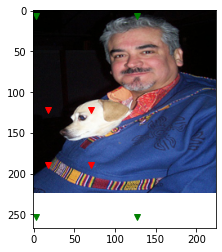

In [55]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    for i in range(0,len(data_test)):
        img,_,_,name = data_test[i]
        (c,w,h) = img.shape
    #    img = img.reshape(w,h,c)
        #print(data_test[i])
        out = model([img])
        boxes,labels = out['boxes'],out['labels']
        img = img.squeeze().permute(1,2,0)
        plt.imshow(img)
        print(boxes)
        colors = ['r','g','k','b']
        for j,box in enumerate(boxes):
                plt.plot(box[0],box[1],marker='v',color=colors[j])
                plt.plot(box[0],box[3],marker='v',color=colors[j])
                plt.plot(box[2],box[1],marker='v',color=colors[j])
                plt.plot(box[2],box[3],marker='v',color=colors[j])
        break

In [ ]:
{'annotation': {'folder': 'VOC2007', 'filename': '006748.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '296363423'}, 'owner': {'flickrid': 'imageautomotiveimage', 'name': '?'}, 'size': {'width': '338', 'height': '500', 'depth': '3'},\
                'segmented': '0', 'object': [{'name': 'car', 'pose': 'Rear', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '47', 'ymin': '265', 'xmax': '213', 'ymax': '385'}}, {'name': 'car', 'pose': 'Rear',\
'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '178', 'ymin': '180', 'xmax': '337', 'ymax': '279'}}, {'name': 'person', 'pose': 'Unspecified', 'truncated': '1', 'difficult': '1', 'bndbox': \
                                                                                                              {'xmin': '228', 'ymin': '183', 'xmax': '249', 'ymax': '202'}}]}}